In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report, recall_score
import joblib



In [14]:
df1=pd.read_csv("URL dataset.csv")
df2=pd.read_csv("Phishing URLs.csv")

combined_df=pd.concat([df1,df2], axis=0, ignore_index=True)

combined_df.drop_duplicates(subset='url', inplace=True)



In [15]:
print(combined_df.head())


                         url        type
0     https://www.google.com  legitimate
1    https://www.youtube.com  legitimate
2   https://www.facebook.com  legitimate
3      https://www.baidu.com  legitimate
4  https://www.wikipedia.org  legitimate


In [16]:
encoder = LabelEncoder()
combined_df['type']=combined_df['type'].astype(str).str.strip().str.lower()
combined_df['label'] = encoder.fit_transform(combined_df['type'])
combined_df = combined_df.dropna(subset=['label']).reset_index(drop=True)
print("NaNs in label column:", combined_df['label'].isna().sum())

print(encoder.classes_)


NaNs in label column: 0
['legitimate' 'phishing']


In [18]:
def extract_url_features(url):
    features={}

    try:
        parsed=urlparse(url)
    except Exception as e:
        parsed=None

    features['url_length']=len(url)

    domain=parsed.netloc if parsed and parsed.netloc else url
    features['domain_length']=len(domain)

    path=parsed.path if parsed else ""
    features['path_length']=len(path)

    features['num_dots']=url.count('.')

    features['num_hyphens']=url.count('-')

    features['num_slashes']=url.count('/')

    features['num_subdomains'] = max(0, domain.count('.') - 1)
    features['multiple_hyphens'] = 1 if domain.count('-') > 1 else 0

    features['has_ipv4']=1 if re.match(r'^\d+\.\d+\.\d+\.\d+$',domain) else 0

    features['has_ipv6']=1 if re.match(r'^\[([0-9a-fA-F:]+)\]$',domain) else 0

    suspicious_tlds = ['tk','ml','ga','cf','gq']
    features['suspicious_tld'] = 1 if domain.split('.')[-1] in suspicious_tlds else 0

    phishing_keywords = ['login','secure','account','verify','update','bank','confirm','signin','webscr','paypal','amazon','apple']
    features['phishing_keyword'] = 1 if any(k in url.lower() for k in phishing_keywords) else 0

    brands = ['paypal','google','amazon','facebook','apple','microsoft']
    features['brand_in_path'] = 1 if any(b in path.lower() for b in brands) else 0

    shorteners = ['bit.ly','tinyurl','goo.gl','t.co','ow.ly']
    features['is_shortened'] = 1 if any(s in url.lower() for s in shorteners) else 0

    if parsed and parsed.scheme:
        features['is_https'] = 1 if parsed.scheme.lower() == 'https' else 0
    else:
        features['is_https'] = 0

    features['num_digits']=sum(c.isdigit() for c in url)

    features['has_at_symbol']=1 if '@' in url else 0
    features['has_encoded_chars'] = 1 if '%' in url else 0

    return features 


In [17]:
feature_list=combined_df['url'].apply(extract_url_features)

features_df=pd.DataFrame(feature_list.tolist())

combined_df=pd.concat([combined_df, features_df],axis=1)


In [ ]:
X=combined_df.drop(columns=['url','type','label'])
y=combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


Training Accuracy: 0.9671243185970402
Testing Accuracy: 0.9319021260162199
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     69125
           1       0.85      0.96      0.90     31862

    accuracy                           0.93    100987
   macro avg       0.91      0.94      0.92    100987
weighted avg       0.94      0.93      0.93    100987

Random forest Confusion Matrix:
 [[63632  5493]
 [ 1384 30478]]
Phishing Recall: 0.95656267654259


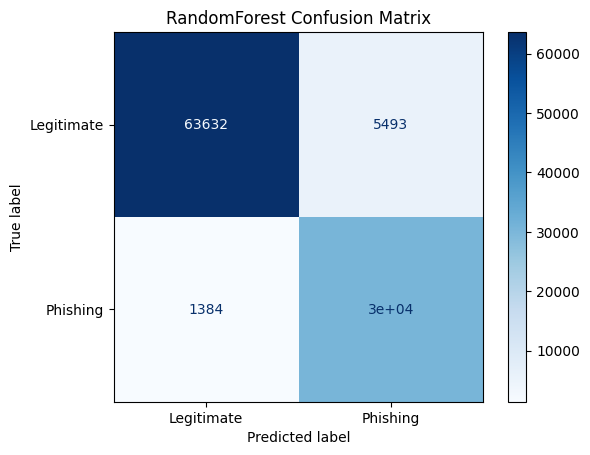

In [19]:
rf_model=RandomForestClassifier(n_estimators=300,max_depth=15,min_samples_split=10,min_samples_leaf=5,class_weight={0:1, 1:2},random_state=42)

rf_model.fit(X_train,y_train)

train_pred=rf_model.predict(X_train)
y_test_proba=rf_model.predict_proba(X_test)[:,1]
threshold=0.25
test_pred=(y_test_proba>= threshold).astype(int)


train_accuracy=accuracy_score(y_train,train_pred)
test_accuracy=accuracy_score(y_test,test_pred)

print("Training Accuracy:",train_accuracy)
print("Testing Accuracy:",test_accuracy)
print(classification_report(y_test,test_pred))

cm_rf=confusion_matrix(y_test,test_pred)
print("Random forest Confusion Matrix:\n",cm_rf)

recall =recall_score(y_test,test_pred)
print("Phishing Recall:", recall)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=["Legitimate", "Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("RandomForest Confusion Matrix")
plt.show()



In [22]:
joblib.dump(rf_model,"phishing_model.pkl")
joblib.dump(X_train.columns.tolist(),"feature_columns.pkl")

['feature_columns.pkl']